# Shakes and Quakes
### *Ordinal Modelling of Earthquake-Induced Building Damages*
### Patricio Hernandez Senosiain
---


## Contents:

>[1 - Introduction](#1---Introduction)
>
>[2 - Imports](#2---Imports)
>
>[3 - Data retrieval and exploratory analysis](#3---Data-retrieval-and-exploratory-analysis)
>
>[4 - Data cleaning and preprocessing](#4---Data-cleaning-and-preprocessing)
>
>[5 - Modelling](#5---Modelling)
>
>[6 - Conclusion](#6---Conclusion)
>


## 1 - Introduction

## 2 - Imports and utilities

### 2.1 - Imports

In [1]:
# Scikit learn - preprocessing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, RobustScaler, FunctionTransformer, LabelEncoder

# Scikit learn - model selection
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold, cross_val_score, cross_validate

# Scikit learn - model evaluation
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Scikit learn - modelling
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsOneClassifier, OutputCodeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA


# CatBoost - modelling
from catboost import CatBoostClassifier

# XGBoost - modelling
from xgboost import XGBClassifier

# LightGBM - modelling
from lightgbm import LGBMClassifier

# Category Encoders - feature encoding
from category_encoders import TargetEncoder, LeaveOneOutEncoder, CatBoostEncoder
from category_encoders.wrapper import PolynomialWrapper

# Pandas and Numpy - data handling
import pandas as pd
import numpy as np

# Plotly, Matplotlib, and Seaborn - visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from qbstyles import mpl_style

from sklearn import set_config

### 2.1 - Utilities

In [2]:
# Setting up utilities

# Matplotlib theme
#mpl_style(dark=True)

# Declaring standard Seaborn color palette
standard_palette = []
for i in range(10):
    standard_palette += list(sns.color_palette('muted'))


# Convergence warning disabling
from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter
    #simplefilter("ignore", category=ConvergenceWarning)

# Setting a random seed
SEED = 105

## 3 - Data retrieval and exploratory analysis

### 3.1 - Data retrieval

In [3]:
train_features = pd.read_csv('data/train_values.csv')
train_target = pd.read_csv('data/train_labels.csv')

### 3.2 - General overview

In [4]:
print('Features data:')
train_features.info(verbose=False)
print('')
print('Target data:')
train_target.info(verbose=False)

Features data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Columns: 39 entries, building_id to has_secondary_use_other
dtypes: int64(31), object(8)
memory usage: 77.5+ MB

Target data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Columns: 2 entries, building_id to damage_grade
dtypes: int64(2)
memory usage: 4.0 MB


In [5]:
train_features.head(10)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0
5,333020,8,558,6089,2,10,9,5,t,r,...,1,0,0,0,0,0,0,0,0,0
6,728451,9,475,12066,2,25,3,4,n,r,...,0,0,0,0,0,0,0,0,0,0
7,475515,20,323,12236,2,0,8,6,t,w,...,0,0,0,0,0,0,0,0,0,0
8,441126,0,757,7219,2,15,8,6,t,r,...,0,0,0,0,0,0,0,0,0,0
9,989500,26,886,994,1,0,13,4,t,i,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train_target.head(10)

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3
5,333020,2
6,728451,3
7,475515,1
8,441126,2
9,989500,1


In [7]:
data = train_features.merge(train_target, on='building_id' )
data = data.drop(columns='building_id')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-null 


#### **NOTES FROM (3.2):**

* (Notes)

It is necessary to further classify features based on their statistical data types. With the aid of the [data description section](https://www.drivendata.org/competitions/57/nepal-earthquake/page/136/), we classified the features as follows:
`geo_level_1_id` 

#### **FEATURE CLASSIFICATION:**
|**Binary**                              |**Categorical**         |**Count**            |**Continuous**     |**Location**|
|----------------------------------------|------------------------|---------------------| ------------------|---|
|`has_superstructure_adobe_mud`          |`land_surface_condition`|`count_floors_pre_eq`|`area_percentage`  |`geo_level_1_id`|
|`has_superstructure_mud_mortar_stone`   |`foundation_type`       |`age`                |`height_percentage`|`geo_level_2_id`|
|`has_superstructure_stone_flag`         |`roof_type`             |`count_families`     |                   |`geo_level_3_id`|
|`has_superstructure_cement_mortar_stone`|`ground_floor_type`     |                     |                   |
|`has_superstructure_mud_mortar_brick`   |`other_floor_type`      |                     |                   |
|`has_superstructure_cement_mortar_brick`|`position`              |                     |                   |
|`has_superstructure_timber`             |`plan_configuration`    |                     |                   |
|`has_superstructure_bamboo`             |`legal_ownership_status`|                     |                   |
|`has_superstructure_rc_non_engineered`  |                        |                     |                   |
|`has_superstructure_rc_engineered`      |                        |                     |                   |
|`has_superstructure_other`              |                        |                     |                   |
|`has_secondary_use`                     |                        |                     |                   |
|`has_secondary_use_agriculture`         |                        |                     |                   |
|`has_secondary_use_hotel`               |                        |                     |                   |
|`has_secondary_use_rental`              |                        |                     |                   |
|`has_secondary_use_institution`         |                        |                     |                   |
|`has_secondary_use_school`              |                        |                     |                   |
|`has_secondary_use_industry`            |                        |                     |                   |
|`has_secondary_use_health_post`         |                        |                     |                   |
|`has_secondary_use_gov_office`          |                        |                     |                   |
|`has_secondary_use_use_police`          |                        |                     |                   |
|`has_secondary_use_other`               |                        |                     |                   |
 
                     
                     

In [8]:
# Classifying features
location_feats = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id' ]
cont_feats = ['area_percentage', 'height_percentage']
count_feats = ['count_floors_pre_eq', 'age', 'count_families']
cat_feats = ['land_surface_condition', 'foundation_type', 'roof_type', 
             'ground_floor_type', 'other_floor_type', 'position', 
             'plan_configuration', 'legal_ownership_status']

binary_feats = data.drop(columns=cont_feats+count_feats+cat_feats+location_feats).columns.tolist()
binary_feats.remove('damage_grade') 

### 3.3 - Distribution of target variable

In [9]:
# Summary statistics for target variable
data['damage_grade'].describe()

count    260601.000000
mean          2.238272
std           0.611814
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           3.000000
Name: damage_grade, dtype: float64

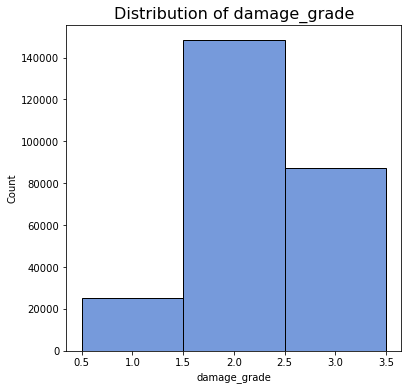

In [10]:
# Plotting distribution of values for target variable
f, axs = plt.subplots(figsize=(6, 6))
sns.histplot(data, x='damage_grade', color=standard_palette[0], fill=True, discrete=True, ax=axs)
plt.title('Distribution of damage_grade', size=16)
plt.show()


#### **NOTES FROM (3.3):**

* (Notes)

### 3.4 - Distribution of continuous features

In [11]:
# Computing summary statistics for continuous features
data[cont_feats].describe()

,area_percentage,height_percentage
count,260601.000000,260601.000000
mean,8.018051,5.434365
std,4.392231,1.918418
min,1.000000,2.000000
25%,5.000000,4.000000
50%,7.000000,5.000000
75%,9.000000,6.000000
max,100.000000,32.000000


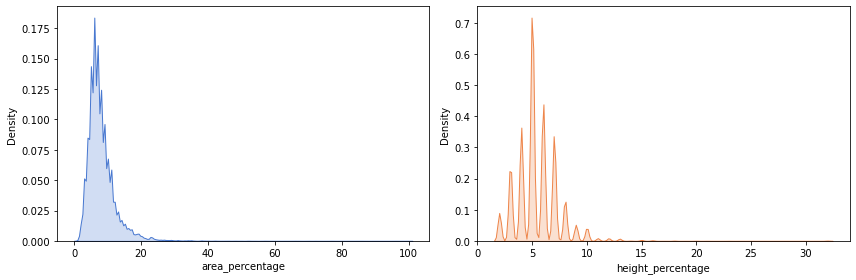

In [12]:
# Plotting distribution of data for continuous features
fig, axs = plt.subplots(1,2)
fig.set_size_inches(12, 4)
for i,feat in enumerate(cont_feats):
    sns.kdeplot(data[feat], 
                ax=axs[i],
                color=standard_palette[i], 
                fill=True)

plt.tight_layout()


#### **NOTES FROM (3.4):**

* Log-transform is required for `area_percentage` to reduce skewness.

### 3.5 - Distribution of count features

In [13]:
# Compute summary statistics for count features
data[count_feats].describe()

,count_floors_pre_eq,age,count_families
count,260601.000000,260601.000000,260601.000000
mean,2.129723,26.535029,0.983949
std,0.727665,73.565937,0.418389
min,1.000000,0.000000,0.000000
25%,2.000000,10.000000,1.000000
50%,2.000000,15.000000,1.000000
75%,2.000000,30.000000,1.000000
max,9.000000,995.000000,9.000000


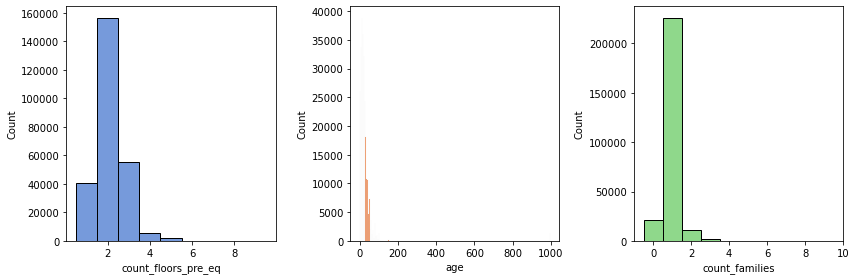

In [14]:
# Plotting distribution of data for count features
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(12, 4)
for i,feat in enumerate(count_feats):
    sns.histplot(x=data[feat],
                 ax=axs[i],
                 color=standard_palette[i],
                 discrete=True)

plt.tight_layout()

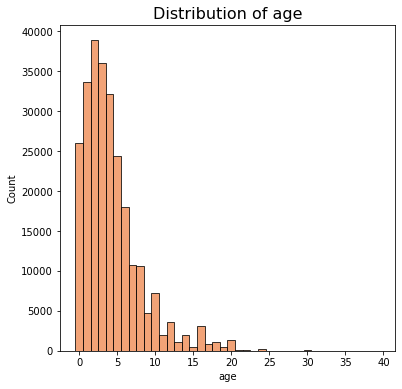

In [15]:
f, axs = plt.subplots(figsize=(6, 6))
transf_age = data[data['age'] < 200]
transf_age = transf_age['age']/5
sns.histplot(x=transf_age, 
             ax=axs, 
             color=standard_palette[1], 
             discrete=True)
plt.title('Distribution of age', size=16)
plt.show()


#### **NOTES FROM (3.3):**

* Significant outliers for `age`. Removal is required.
* Log-transform and scaling by 5 required for `age`.

### 3.6 - Distribution of binary and categorical features

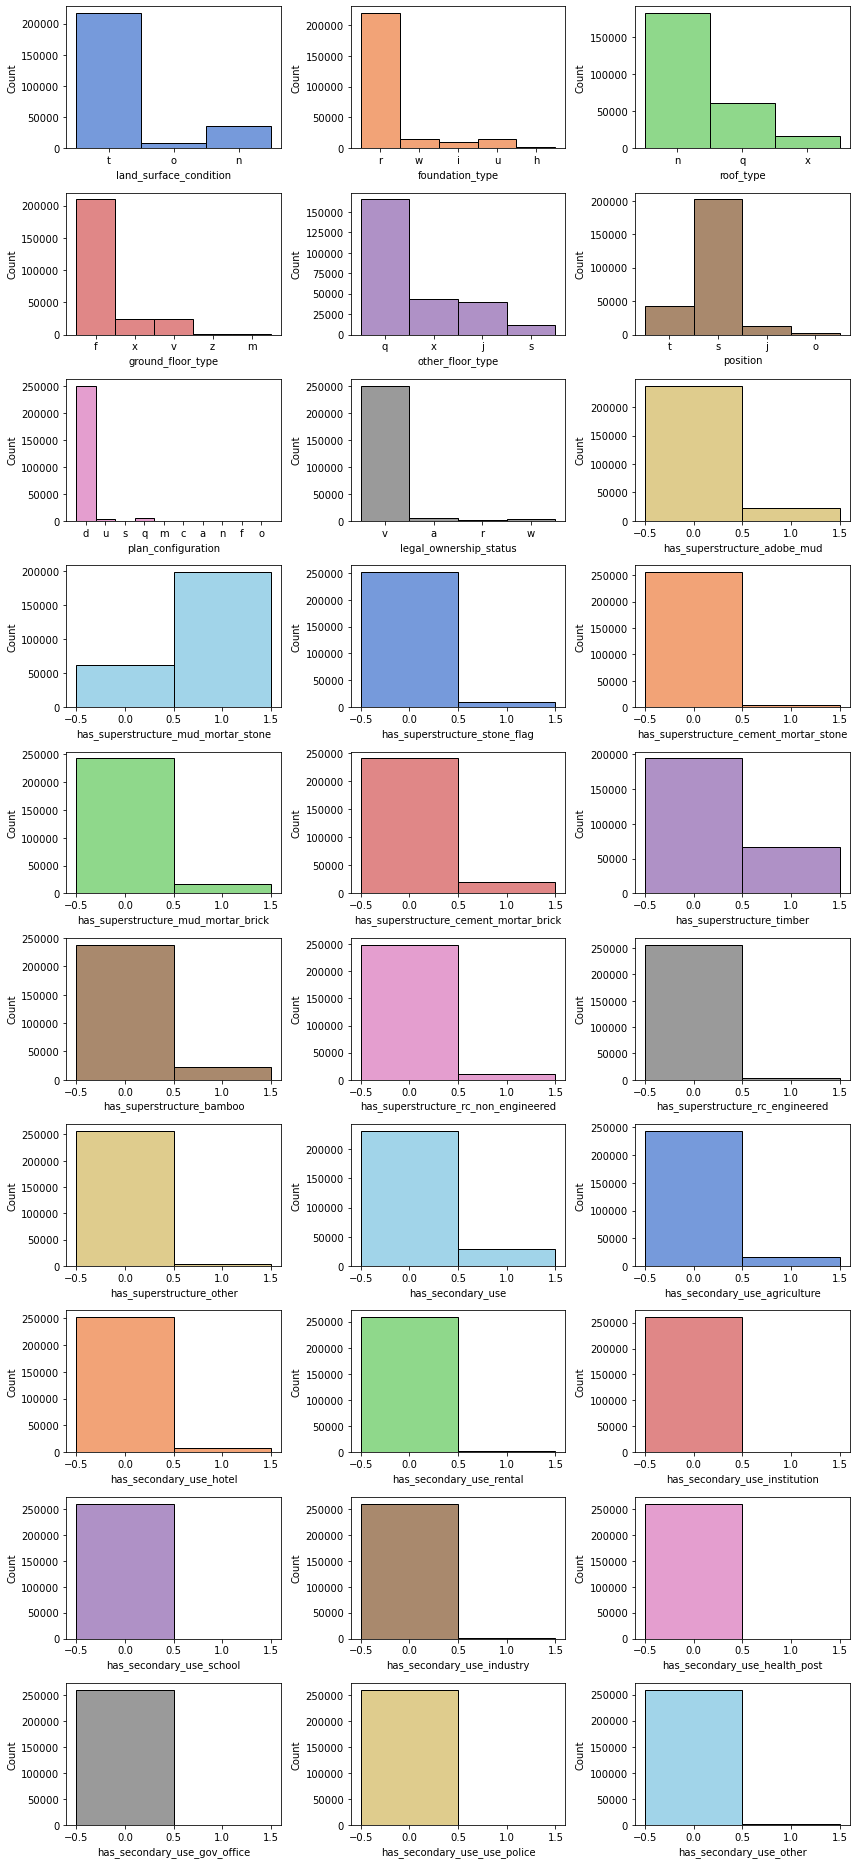

In [16]:
# Plotting distribution of data for categorical features
fig, axs = plt.subplots(10, 3)
fig.set_size_inches(12, 26)
for i,feat in enumerate(cat_feats+binary_feats):
    sns.histplot(x=data[feat],
                 ax=axs[i//3, i % 3],
                 discrete=True,
                 color=standard_palette[i])
    
plt.tight_layout()


#### **NOTES FROM (3.3):**
* Categorical encoding required

### 3.7 - Distribution of location features (find how to display hierarchies)

<AxesSubplot:xlabel='geo_level_1_id', ylabel='Count'>

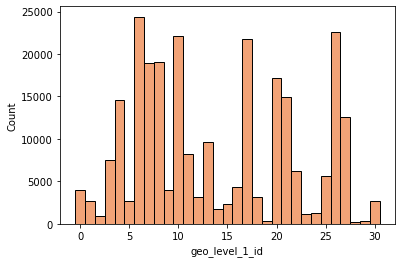

In [17]:
# Distribution of location level 1
sns.histplot(x=data['geo_level_1_id'], 
             color=standard_palette[1], 
             discrete=True)

In [18]:
# Checking for at least one occurence of each id in interval
loc1_vals = (data['geo_level_1_id'].unique()).tolist()
loc2_vals = (data['geo_level_2_id'].unique()).tolist()
loc3_vals = (data['geo_level_3_id'].unique()).tolist()

print('Missing from loc1: ', len(set(range(31)) - set(loc1_vals)))
print('Missing from loc2: ', len(set(range(1428)) - set(loc2_vals)))
print('Missing from loc3: ', len(set(range(12568)) - set(loc3_vals)))

Missing from loc1:  0
Missing from loc2:  14
Missing from loc3:  973


In [19]:
# Uncovering hierarchies
level_2_h = {str(i):set() for i in range(1428)}
level_3_h = {str(i):set() for i in range(12568)}
for i in range(data.shape[0]):
    level_2_h[str(data['geo_level_2_id'].iloc[i])].add(data['geo_level_1_id'].iloc[i])
    level_3_h[str(data['geo_level_3_id'].iloc[i])].add(data['geo_level_2_id'].iloc[i])

for key in level_2_h:
    if len(level_2_h[key]) >1:
        print('Node:', key )
        print('Parents:', level_2_h[key] )
        
for key in level_3_h:
    if len(level_3_h[key]) >1:
        print('Node:', key )
        print('Parents:', level_2_h[key] )    
        


#### **NOTES FROM (3.7):**

* Significant outliers for `age`. Removal is required.
* Log-transform and scaling by 5 required for `age`.

### 3.7 - Bivariate analysis of continuous features

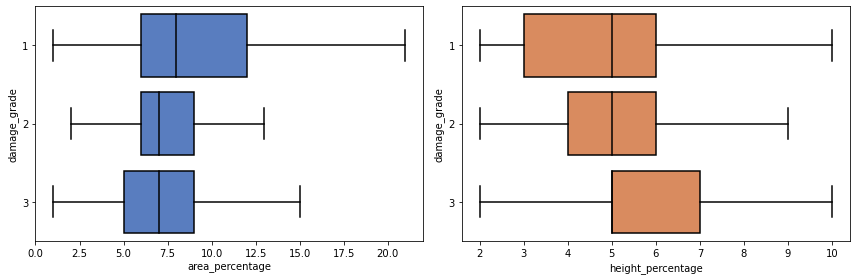

In [20]:
# Plotting boxplots of continuous features versus target variable

props ={'boxprops': {'edgecolor': 'black'}, 
        'medianprops': {'color': 'black'}, 
        'whiskerprops': {'color': 'black'}, 
        'flierprops': {'color': 'black'}, 
        'showfliers': False, 
        'capprops': {'color': 'black'}
       }

fig, axs = plt.subplots(1,2)
fig.set_size_inches(12, 4)
for i,feat in enumerate(cont_feats):
    sns.boxplot(x=data[feat], 
                y=data['damage_grade'],
                ax=axs[i],
                orient='h',
                color=standard_palette[i], 
                **props)

plt.tight_layout()

### 3.8 - Bivariate analysis of count features

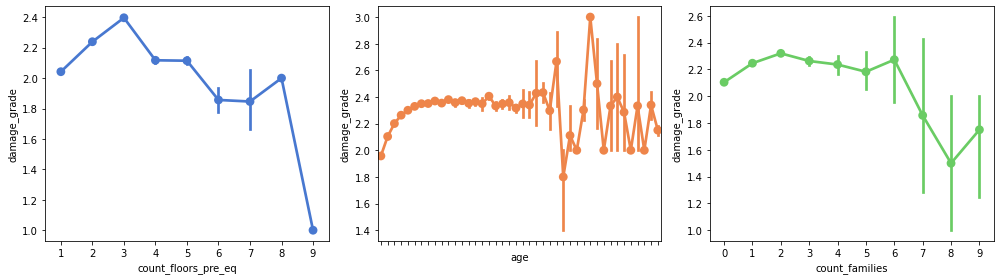

In [21]:
# Plotting mean ln(1+SalePrice) for discrete features
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(14, 4)
for i,feat in enumerate(count_feats):
    p = sns.pointplot(x=data[feat],
                      y=data['damage_grade'],
                      ax=axs[i],
                      color=standard_palette[i])
    if i in [1]:
        p.set(xticklabels=[])
plt.tight_layout()    

### 3.9 - Bivariate analysis of categorical and binary features

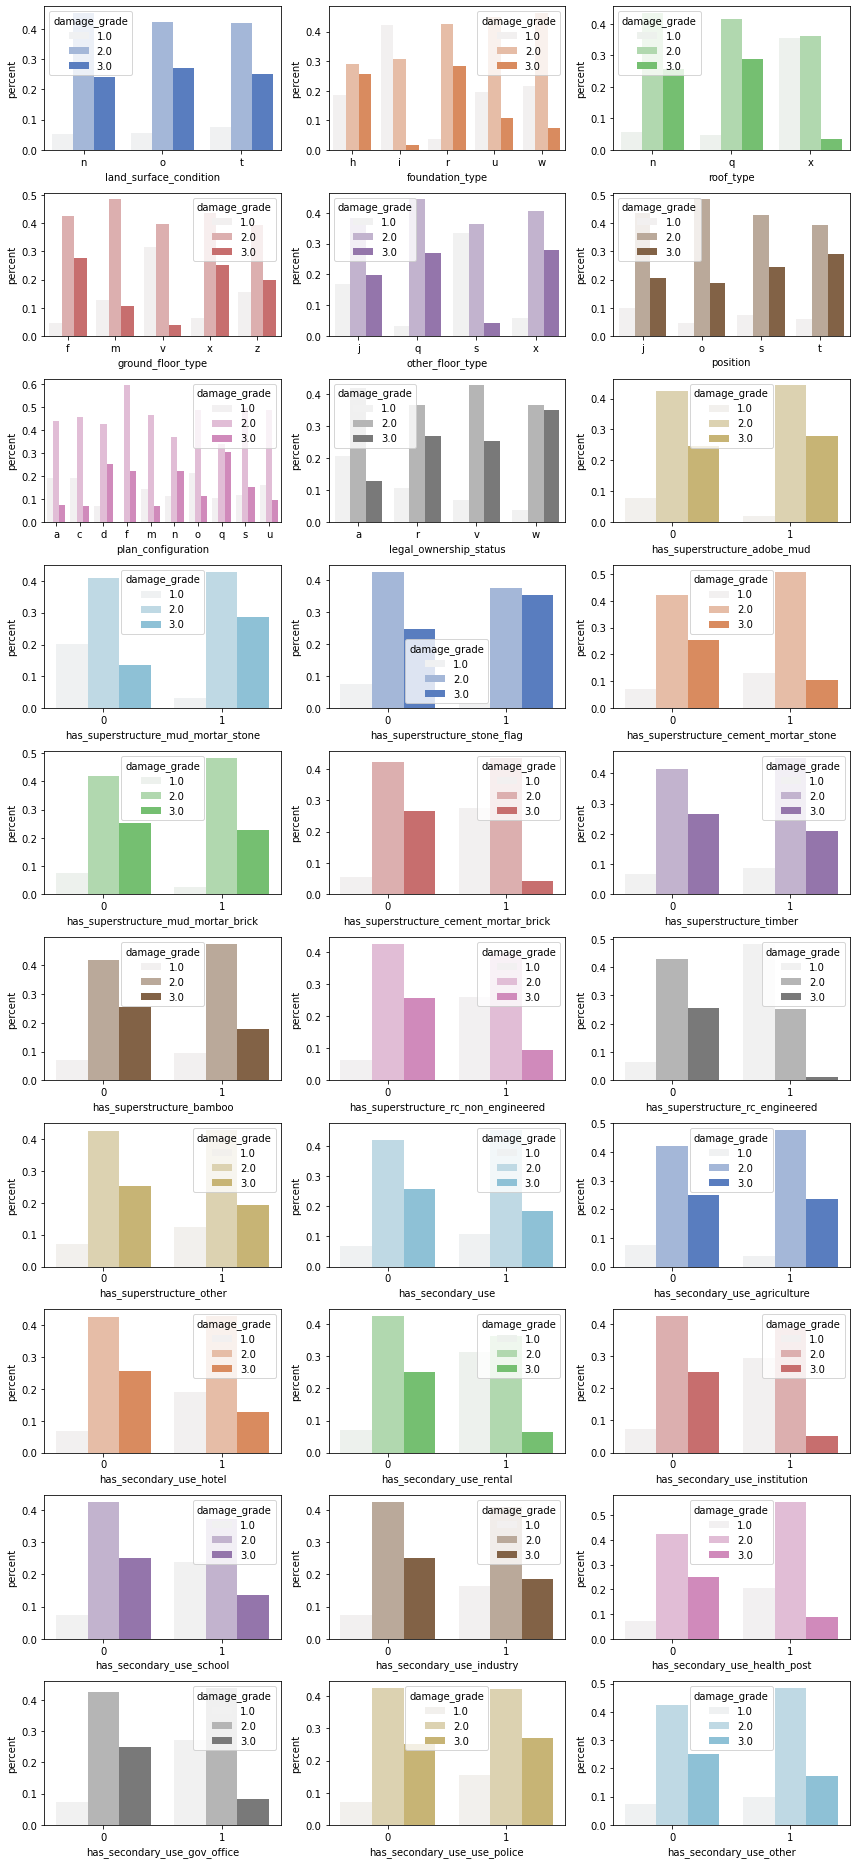

In [46]:
fig, axs = plt.subplots(10, 3)
fig.set_size_inches(12, 26)
for i,feat in enumerate(cat_feats+binary_feats):
    pct = data.groupby([feat,'damage_grade']).size() / data.groupby([feat]).size() 
    pct = pct.reset_index().rename({0:'percent'}, axis=1)
    sns.barplot(x=feat,
                y='percent',
                hue='damage_grade',
                data=pct,
                ax=axs[i//3, i % 3], 
                color=standard_palette[i])

plt.tight_layout()

### 3.10 - Correlation between features

## 4 - Data cleaning

### 4.1 - Outliers

In [23]:
data = data[data['age'] < 100]

### 4.2 - Retrieving and merging test data

In [24]:
# Retrieving test data and printing general overview
test_data = pd.read_csv('data/test_values.csv')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86868 entries, 0 to 86867
Data columns (total 39 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   building_id                             86868 non-null  int64 
 1   geo_level_1_id                          86868 non-null  int64 
 2   geo_level_2_id                          86868 non-null  int64 
 3   geo_level_3_id                          86868 non-null  int64 
 4   count_floors_pre_eq                     86868 non-null  int64 
 5   age                                     86868 non-null  int64 
 6   area_percentage                         86868 non-null  int64 
 7   height_percentage                       86868 non-null  int64 
 8   land_surface_condition                  86868 non-null  object
 9   foundation_type                         86868 non-null  object
 10  roof_type                               86868 non-null  object
 11  gr

In [25]:
# Separating 'Id' column
ID = test_data['building_id']
test_data = test_data.drop(columns='building_id')

# Joining test and training datasets
data = data.append(test_data, sort=False)

# Printing dataset summary
print('')
print('Merged dataset')
data.info(verbose=False)
print('')



Merged dataset
<class 'pandas.core.frame.DataFrame'>
Int64Index: 343981 entries, 0 to 86867
Columns: 39 entries, geo_level_1_id to damage_grade
dtypes: float64(1), int64(30), object(8)
memory usage: 105.0+ MB



In [26]:
data.head(10)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3.0
1,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,2.0
2,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3.0
3,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,2.0
4,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,3.0
5,8,558,6089,2,10,9,5,t,r,n,...,0,0,0,0,0,0,0,0,0,2.0
6,9,475,12066,2,25,3,4,n,r,n,...,0,0,0,0,0,0,0,0,0,3.0
7,20,323,12236,2,0,8,6,t,w,q,...,0,0,0,0,0,0,0,0,0,1.0
8,0,757,7219,2,15,8,6,t,r,q,...,0,0,0,0,0,0,0,0,0,2.0
9,26,886,994,1,0,13,4,t,i,n,...,0,0,0,0,0,0,0,0,0,1.0


### 4.8 - Feature transforms pre modelling

In [27]:
data['area_percentage'] = np.log1p(data['area_percentage']) 

data['age'] = np.log1p(data['age']/5)


geo_level_1_cats = range(31)
geo_level_2_cats = range(1428)
geo_level_3_cats = range(12568)

location_categories = [geo_level_1_cats, geo_level_2_cats, geo_level_3_cats]



## 5 - Modelling

### 5.1 - Evaluation metrics


Although this is an ordinal regression problem, the metric used by Driven Data to evaluate models for this competition is the micro averaged F1 score across the three classes:

$$ F_{micro} \; = \; \frac{2 \cdot P_{micro} \cdot R_{micro} }{P_{micro} + R_{micro} }$$

where $P_{micro}$ and $R_{micro}$ stand for the precision and recall metrics :


$$ P_{micro} \;=\; \frac{\sum^3_{k=1} TP_k}{\sum^3_{k=1}TP_k + FP_k} \;,\; R_{micro} \;=\; \frac{\sum^3_{k=1}TP_k}{\sum^3_{k=1}TP_k + TN_k} $$

In [28]:
def model_score(y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    print('Confusion Matrix')
    print(cm)
    print('')
    
    # Classification report
    print('Classification Report')
    print(classification_report(y_true, y_pred))
    print('')
    print('Micro F1 Score')
    print(f1_score(y_true, y_pred, average='micro'))
    
    return f1_score(y_true, y_pred, average='micro')

### 5.2 - Defining feature matrices and target vectors

In [29]:
# Separating training and test matrices
train = data[data['damage_grade'].isnull()==False]
test = data[data['damage_grade'].isnull()]

# Creating feature matrix and target vector from training sample
X_train = train.drop(columns='damage_grade')
y_train = train['damage_grade']

# Creating feature matrix from test sample
X_test = test.drop(columns='damage_grade')


### 5.3 - Logistic regression modelling

In [30]:
# Creating logistic regression preprocessing pipeline
log_reg_preprocessing_pipe = ColumnTransformer(
    [('continuous', make_pipeline(RobustScaler(), PCA(whiten=True)), cont_feats), 
     ('categorical', OneHotEncoder(), cat_feats), 
     ('location', OneHotEncoder(categories=location_categories), location_feats)
    ], 
    remainder='passthrough'
)     

In [31]:
# Creating Logistic Regression pipeline --- hyperparameter has been optimized
log_reg_pipeline = Pipeline([('preprocessing', log_reg_preprocessing_pipe),
                             ('model', LogisticRegression(multi_class='multinomial',
                                                          max_iter=1600,
                                                          random_state=SEED))])

# Running initial 10 - fold cross validation
print('Running Logistic Regression ...')
%time cv = cross_val_score(log_reg_pipeline, X_train, y_train,scoring=make_scorer(model_score),cv=5, n_jobs=-1)
print('Finished running')
print('Score: ', cv)

Running Logistic Regression ...
CPU times: user 689 ms, sys: 284 ms, total: 974 ms
Wall time: 4min 56s
Finished running
Score:  [0.7451335  0.73972736 0.74628085 0.74483684 0.74596476]


### 5.4 - SVM modelling

In [32]:
# Creating SVM preprocessing pipeline
svm_preprocessing_pipe = ColumnTransformer(
    [('continuous', make_pipeline(RobustScaler(), PCA(whiten=True)), cont_feats), 
     ('categorical', OneHotEncoder(), cat_feats), 
     ('location', OneHotEncoder(categories=location_categories), location_feats)
    ], 
    remainder='passthrough'
)    
svm_params = {'model__estimator__C': np.logspace(-1,1,20) }

In [33]:
# Creating SVM pipeline --- hyperparameter has been optimized
svm_pipeline = Pipeline([('preprocessing', svm_preprocessing_pipe),
                         ('model', OneVsOneClassifier(LinearSVC(random_state=SEED,
                                                                C=6.5,
                                                                dual=False)))])

# Running initial 10 - fold cross validation
print('Running SVM ...')
%time cv = cross_val_score(svm_pipeline, X_train, y_train,scoring=make_scorer(model_score),cv=5, n_jobs=-1)
print('Finished running')
print('Score: ', cv)

Running SVM ...
CPU times: user 526 ms, sys: 95 ms, total: 621 ms
Wall time: 1min 42s
Finished running
Score:  [0.74206095 0.73647979 0.74338331 0.74260044 0.74318385]


### 5.5 - Random forest modelling

In [34]:
# Creating Random Forest preprocessing pipeline
rf_preprocessing_pipe = ColumnTransformer( 
    [('categorical', OneHotEncoder(), cat_feats), 
     ('location', OneHotEncoder(categories=location_categories), location_feats) 
    ], 
    remainder='passthrough') 

# Hyperparameters for Random Forest regressor
rf_params = {'model__n_estimators': np.arange(200, 350, 10),
             'model__max_depth': np.arange(20, 60, 2),
             'model__min_samples_split': np.arange(36, 160, 2),
             'model__min_samples_leaf': np.arange(1, 14, 1) 
             }

In [35]:
# Creating Random Forest pipeline --- hyperparameter has been optimized
rf_pipeline = Pipeline([('preprocessing', rf_preprocessing_pipe), 
                        ('model', RandomForestClassifier(n_estimators=350,
                                                         max_depth=40,
                                                         min_samples_split=46,
                                                         min_samples_leaf=8,
                                                         random_state=SEED))])
 
## Running initial 10 - fold cross validation 
#print('Running Random Forest ...')
#%time cv = cross_val_score(rf_pipeline, X_train, y_train,scoring=make_scorer(model_score),cv=5, n_jobs=-1)
#print('Finished running')
#print('Score: ', cv)

### 5.6 - Multilayer Perceptron modelling

In [36]:
# Creating MLP preprocessing pipeline
mlp_preprocessing_pipe = ColumnTransformer( 
    [('categorical', OneHotEncoder(), cat_feats), 
     ('location', OneHotEncoder(categories=location_categories), location_feats)
    ], 
    remainder='passthrough') 

In [37]:
# FIX THIS!!!!!
# Creating MLP pipeline
mlp_pipeline = Pipeline([('preprocessing', mlp_preprocessing_pipe),
                         ('model', MLPClassifier())])
## Running initial 5-fold cross validation 
#print('Running MLP ...')
#%time cv = cross_val_score(mlp_pipeline, X_train, y_train, scoring=make_scorer(model_score),cv=5, n_jobs=-1)
#print('Finished running')
#print('Score: ', cv)

### 5.7 - Catboost modelling

In [38]:
# Creating CatBoost pipeline
catboost_pipeline = Pipeline([ ('model', CatBoostClassifier(cat_features=cat_feats + location_feats, 
                                                            loss_function='MultiClass'))])
# Running initial 5-fold cross validation 
#print('Running CatBoost ...')
#%time cv = cross_val_score(catboost_pipeline, X_train, y_train, scoring=make_scorer(model_score),cv=5, n_jobs=-1)
#print('Finished running')
#print('Score: ', cv)

### 5.8 - XGBoost modelling

In [39]:
# Creating XGBoost preprocessing pipeline
xgboost_preprocessing_pipe = ColumnTransformer( 
    [('categorical', OneHotEncoder(), cat_feats), 
     ('location', OneHotEncoder(categories=location_categories), location_feats)
    ], 
    remainder='passthrough') 
#TODOD: ADD PIPELINE STEP TO ENCODE AND DE-ENCODE TARGET Y AS 0,1,2 RATHER THAN 1,2,3

In [40]:
# Creating XGBoost pipeline
xgboost_pipeline = Pipeline([('preprocessing', xgboost_preprocessing_pipe), 
                             ('model', XGBClassifier(objective='multi:softmax', 
                                                     num_class=3))])
## Running initial 5-fold cross validation 
#print('Running XGBoost ...')
#%time cv = cross_val_score(xgboost_pipeline, X_train, y_train, scoring=make_scorer(model_score),cv=5, n_jobs=-1)
#print('Finished running')
#print('Score: ', cv)

### 5.8 - LightGBM modelling

In [41]:
# Creating LightGBM preprocessing pipeline
lgbm_preprocessing_pipe = ColumnTransformer(
    [('categorical', OneHotEncoder(), cat_feats), 
     ('location', OneHotEncoder(categories=location_categories), location_feats)
    ], 
    remainder='passthrough') 

In [42]:
# Creating LightGBM pipeline
lgbm_pipeline = Pipeline([('preprocessing', lgbm_preprocessing_pipe),
                          ('model', LGBMClassifier(objective='multiclass', 
                                                   num_class=3))])
## Running initial 5-fold cross validation 
#print('Running LightGBM ...')
#%time cv = cross_val_score(lgbm_pipeline, X_train, y_train, scoring=make_scorer(model_score),cv=5, n_jobs=-1)
#print('Finished running')
#print('Score: ', cv)

### 5.9 - Estimator stacking

In [43]:
# Preparing best estimators to pass into stacked model
final_estimators = [('CatBoost', catboost_pipeline),
                    ('LightGBM', lgbm_pipeline),
                    ('XGBoost', xgboost_pipeline),
                    ('Random Forest', rf_pipeline), 
                    ('SVM', svm_pipeline), 
                    ('Logistic Regression', log_reg_pipeline)]

methods = {'CatBoost':'predict',
           'XGBoost':'predict',
           'Random Forest':'predict', 
           'SVM':'decision_function', 
           'Logistic Regression':'predict_proba'}
#stack = StackingClassifier(estimators=final_estimators, cv=5)

#print('Running stacked estimator model...')
#%time cv = cross_val_score(stack, X_train, y_train, scoring=make_scorer(model_score), cv=5, n_jobs=-1)
#print('Finished running')
#print('Score: ', cv)

### 5.9 - Final model

In [44]:
# Create estimator with optimal hyperparameters
final_model = StackingClassifier(final_estimator = LogisticRegression(multi_class='multinomial',
                                                                      max_iter=1600,
                                                                      random_state=SEED), 
                                 estimators=final_estimators, 
                                 n_jobs=-1)

set_config(display='diagram')
final_model

StackingClassifier(estimators=[('CatBoost',
                                Pipeline(steps=[('model',
                                                 <catboost.core.CatBoostClassifier object at 0x7f8c0a30f370>)])),
                               ('LightGBM',
                                Pipeline(steps=[('preprocessing',
                                                 ColumnTransformer(remainder='passthrough',
                                                                   transformers=[('categorical',
                                                                                  OneHotEncoder(),
                                                                                  ['land_surface_condition',
                                                                                   'foundation_type',
                                                                                   'roof_type',
                                                                                   'ground_floor_type',
                                                                                   'other_floor_...
                                                                                   'legal_ownership_status']),
                                                                                 ('location',
                                                                                  OneHotEncoder(categories=[range(0, 31),
                                                                                                            range(0, 1428),
                                                                                                            range(0, 12568)]),
                                                                                  ['geo_level_1_id',
                                                                                   'geo_level_2_id',
                                                                                   'geo_level_3_id'])])),
                                                ('model',
                                                 LogisticRegression(max_iter=1600,
                                                                    multi_class='multinomial',
                                                                    random_state=105))]))],
                   final_estimator=LogisticRegression(max_iter=1600,
                                                      multi_class='multinomial',
                                                      random_state=105),
                   n_jobs=-1)

## 6 - Final predictions and submission

In [45]:
# Fit model with complete training sample
final_model.fit(X_train, y_train)

# Creating submission file
preds = final_model.predict(X_test)
preds = preds.flatten()
output = pd.DataFrame( {'building_id': ID, 'damage_grade': preds})
output = output.astype(int)
output.to_csv('submission.csv', index=False)